# Examine a Single Event

In this example we will generate a single event with a given vertex, direction, and energy, and then we'll examine the event by plotting the waveforms. This is typically useful for auditing events from a larger simulation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyrex
import pyrex.custom.ara as ara

First let's rebuild our detector that was used in the simulation.

In [2]:
det = ara.HexagonalGrid(station_type=ara.RegularStation,
                        stations=1, lowest_antenna=-100)
det.build_antennas(power_threshold=-6.15)

Then let's plot a couple views of it just to be sure everything looks right.

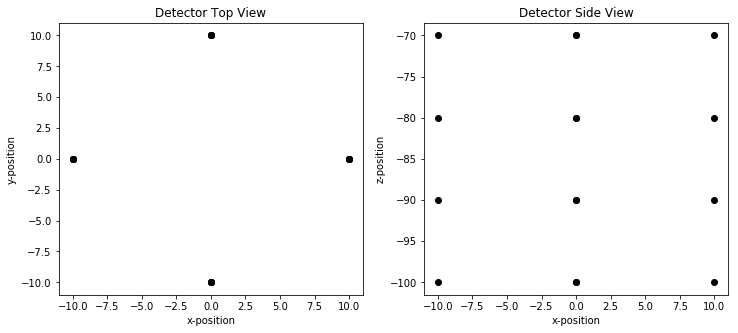

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter([ant.position[0] for ant in det],
              [ant.position[1] for ant in det],
              c='k')
ax[0].set_title("Detector Top View")
ax[0].set_xlabel("x-position")
ax[0].set_ylabel("y-position")
ax[1].scatter([ant.position[0] for ant in det],
              [ant.position[2] for ant in det],
              c='k')
ax[1].set_title("Detector Side View")
ax[1].set_xlabel("x-position")
ax[1].set_ylabel("z-position")
plt.show()

Now set up a particle generator that will just throw the one event we're interested in, and create an event kernel with our detector and our generator.

In [4]:
p = pyrex.Particle(vertex=[1002.65674195, -421.95118348, -586.0953201],
                   direction=[-0.90615395, -0.41800062, -0.06450191],
                   energy=1e9)
gen = pyrex.ListGenerator(p)
kern = pyrex.EventKernel(antennas=det, generator=gen)

Then make sure our detector is cleared out and throw the event! reset_noise will make sure we get new noise waveforms every time.

In [5]:
det.clear(reset_noise=True)
kern.event()

Now let's take a look at the waveforms of the event. Since each event has a first and second ray, plot their waveforms side-by-side for each antenna.

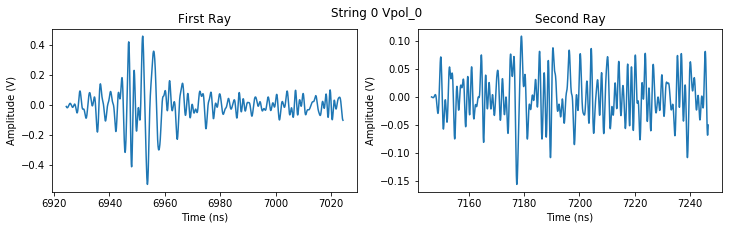

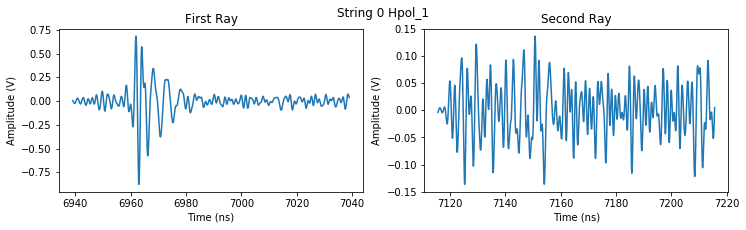

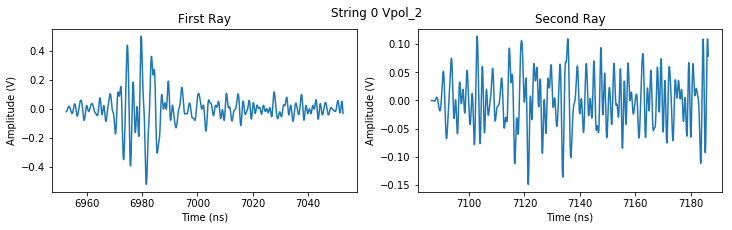

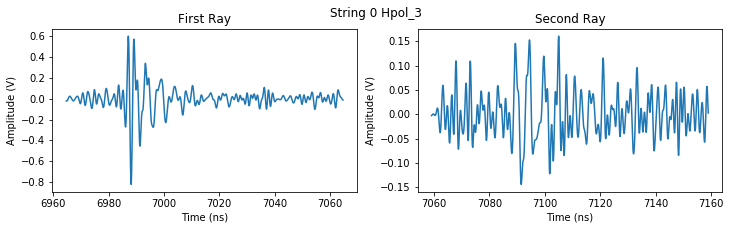

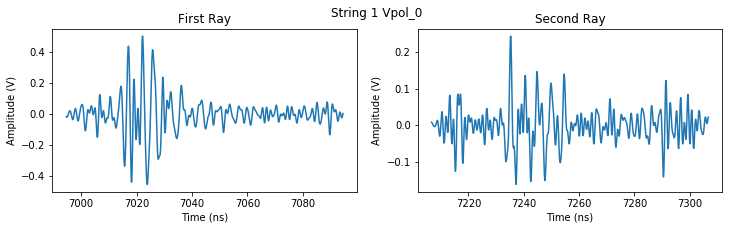

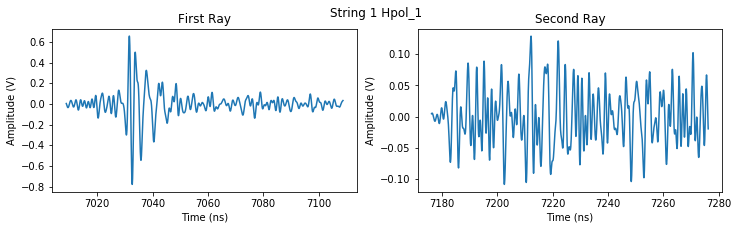

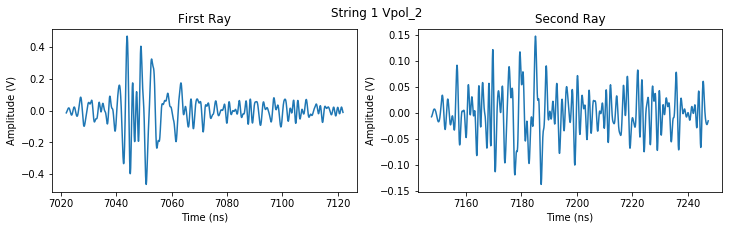

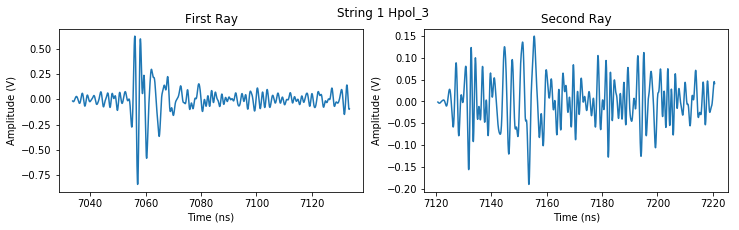

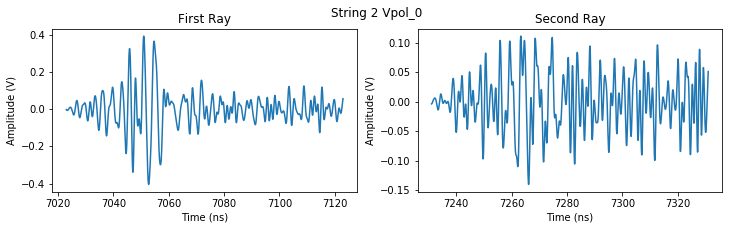

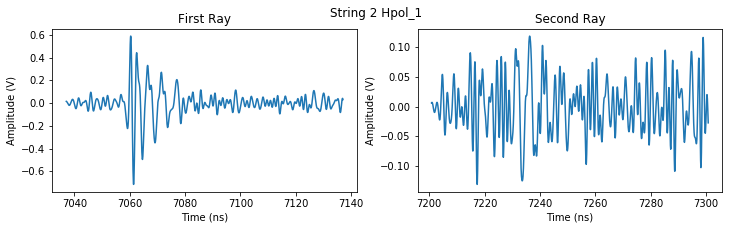

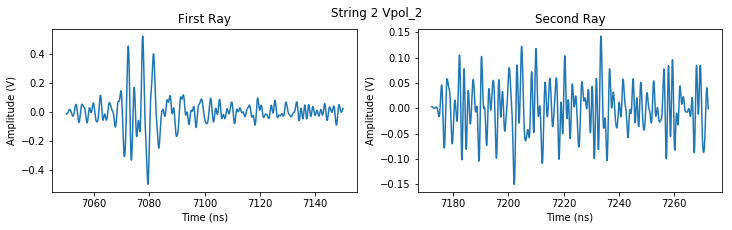

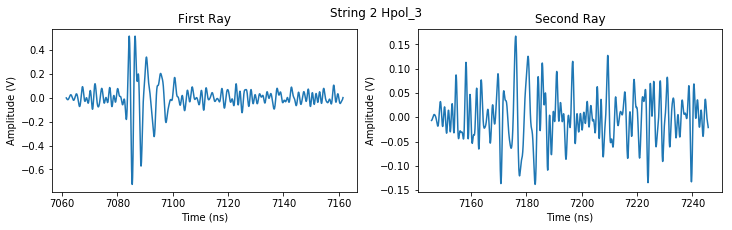

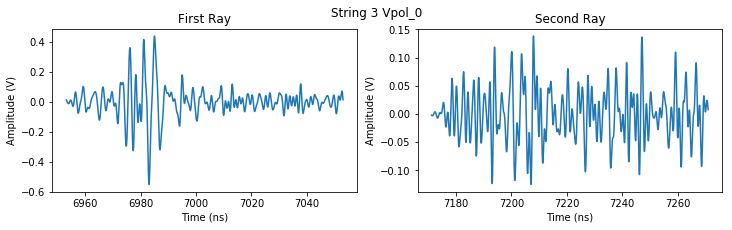

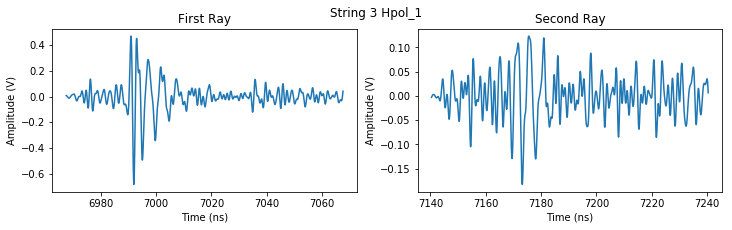

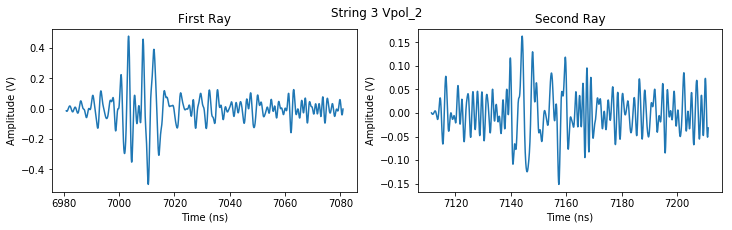

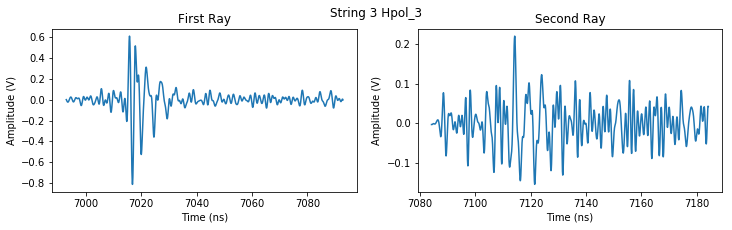

In [6]:
for i, ant in enumerate(det):
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    for j, wave in enumerate(ant.all_waveforms):
        ax[j].plot(wave.times*1e9, wave.values)
        ax[j].set_xlabel("Time (ns)")
        ax[j].set_ylabel("Amplitude (V)")
        ax[j].set_title("First Ray" if j%2==0 else "Second Ray")
    fig.suptitle("String "+str(int(i/4))+" "+ant.name)
    plt.show()

From the plots it looks like the first ray is the one that triggered the detector. Let's calculate a signal-to-noise ratio of the first-ray waveform for each antenna.

In [7]:
print("Signal-to-noise ratios:")
for i, ant in enumerate(det):
    wave = ant.all_waveforms[0]
    signal_pp = np.max(wave.values) - np.min(wave.values)
    noise = ant.front_end(ant.antenna.make_noise(wave.times))
    noise_rms = np.sqrt(np.mean(noise.values**2))
    print("  String "+str(int(i/4))+" "+ant.name+":", signal_pp/(2*noise_rms))

Signal-to-noise ratios:
  String 0 Vpol_0: 11.334319819211622
  String 0 Hpol_1: 22.38987270443744
  String 0 Vpol_2: 14.157506412028026
  String 0 Hpol_3: 18.28580167319089
  String 1 Vpol_0: 13.740126927285054
  String 1 Hpol_1: 17.36640446007192
  String 1 Vpol_2: 11.846106155697147
  String 1 Hpol_3: 16.044387354296834
  String 2 Vpol_0: 10.282293920836073
  String 2 Hpol_1: 15.746935360523715
  String 2 Vpol_2: 15.419092353134536
  String 2 Hpol_3: 15.743337700031931
  String 3 Vpol_0: 13.28831014195805
  String 3 Hpol_1: 15.208268969146735
  String 3 Vpol_2: 12.182034132974271
  String 3 Hpol_3: 20.717202031844355


Let's also take a look at the trigger condition, which passes the waveform through a tunnel diode. Again we can plot the tunnel diode's integrated waveform for each ray side-by-side. The red lines indicate the trigger level. If the integrated waveform goes beyond those lines the antenna is triggered.

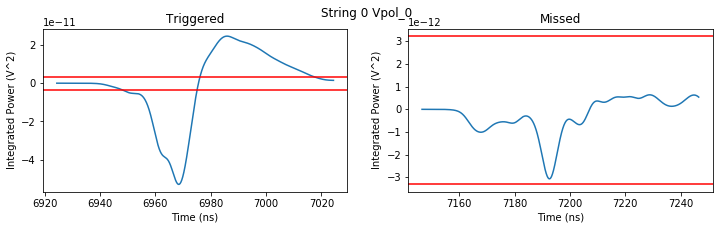

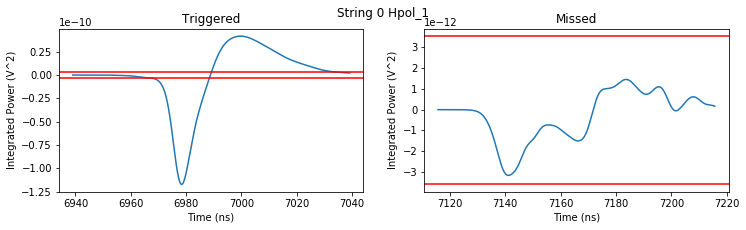

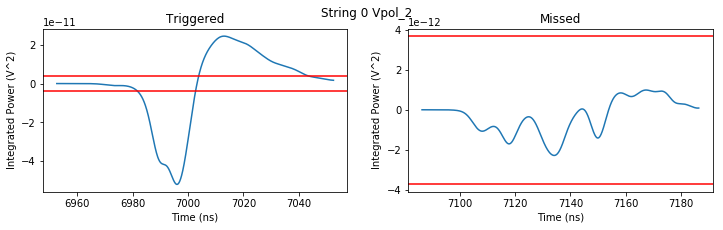

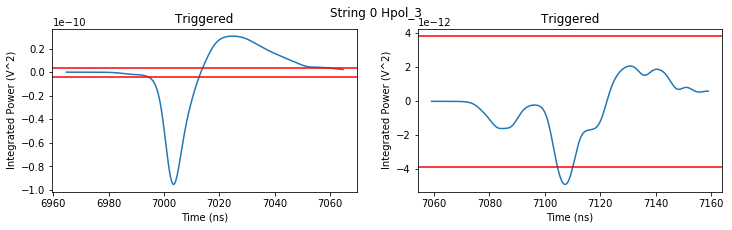

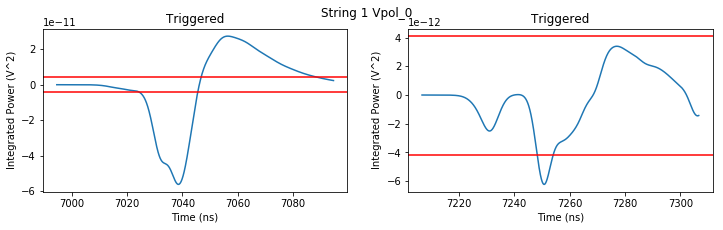

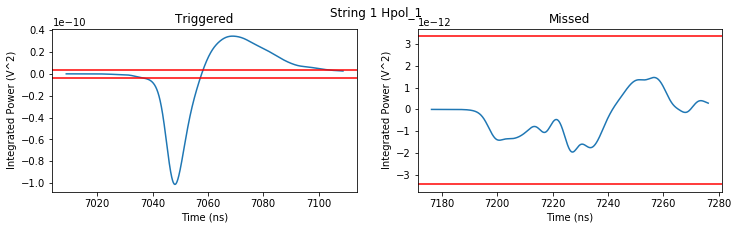

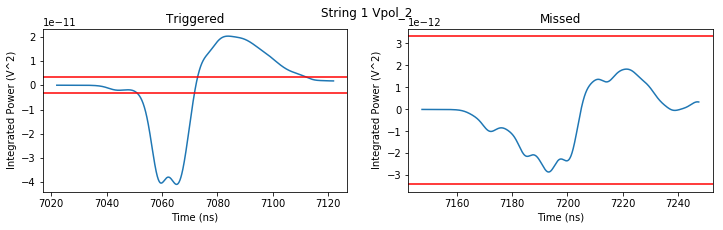

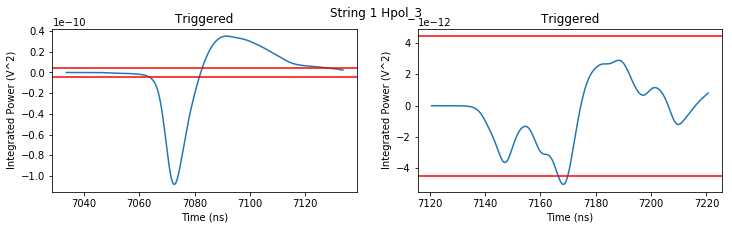

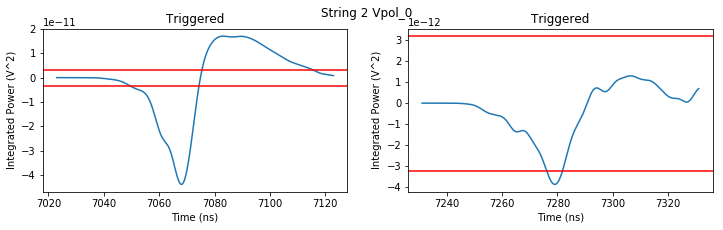

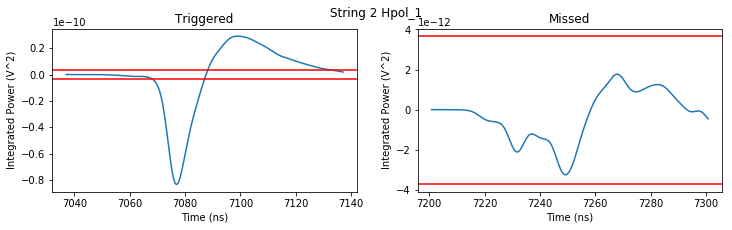

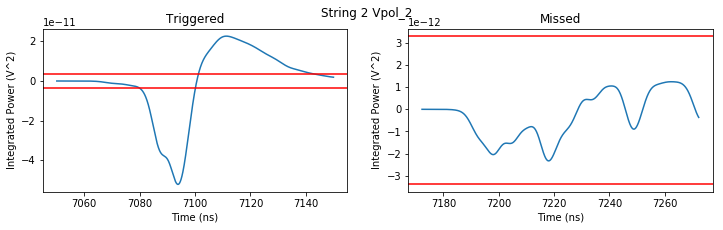

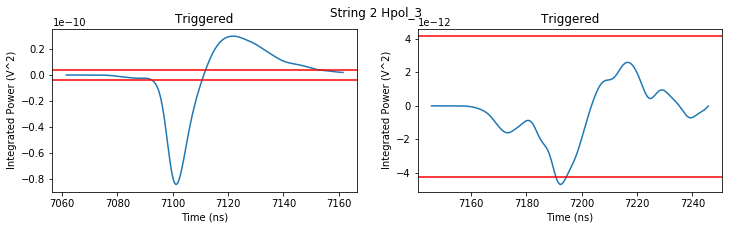

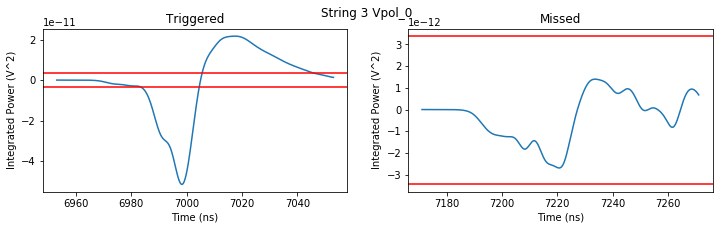

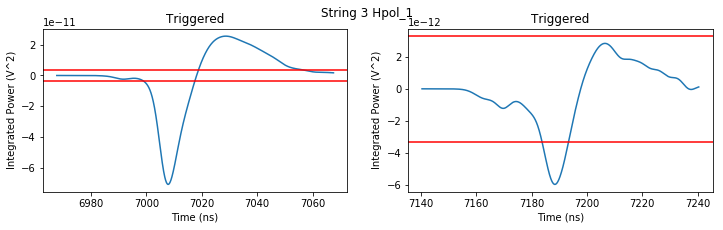

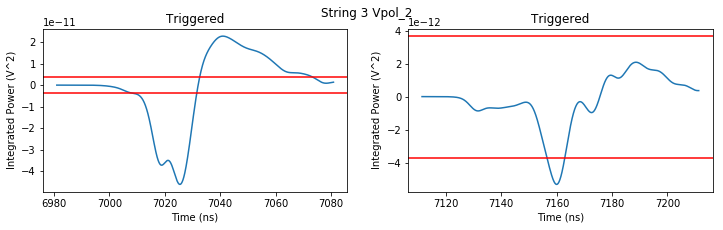

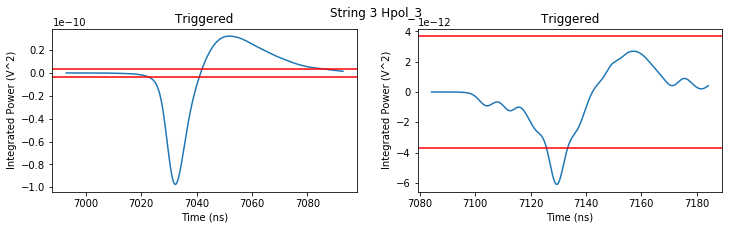

In [8]:
for i, ant in enumerate(det):
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    for j, wave in enumerate(ant.all_waveforms):
        triggered = ant.trigger(wave)
        trigger_wave = ant.tunnel_diode(wave)
        # The first time ant.trigger is run for an antenna, the power mean
        # and rms are calculated which will determine the trigger condition.
        low_trigger = (ant._power_mean -
                       ant._power_rms*np.abs(ant.power_threshold))
        high_trigger = (ant._power_mean +
                        ant._power_rms*np.abs(ant.power_threshold))
        ax[j].plot(trigger_wave.times*1e9, trigger_wave.values)
        ax[j].axhline(low_trigger, color='r')
        ax[j].axhline(high_trigger, color='r')
        ax[j].set_title("Triggered" if triggered else "Missed")
        ax[j].set_xlabel("Time (ns)")
        ax[j].set_ylabel("Integrated Power (V^2)")
    fig.suptitle("String "+str(int(i/4))+" "+ant.name)
    plt.show()

Finally, let's look at the relative trigger times to make sure they look reasonable. We could get the true relative trigger times from the waveforms by just taking the differences of their first times, but instead let's pretend we're doing an analysis and just use the times of the maxima.

In [9]:
trig_times = []
for ant in det:
    wave = ant.all_waveforms[0]
    trig_times.append(wave.times[np.argmax(np.abs(wave.values))])

Then we can plot the progression of the event by coloring the antennas where red is the earliest time and blue/purple is the latest time.

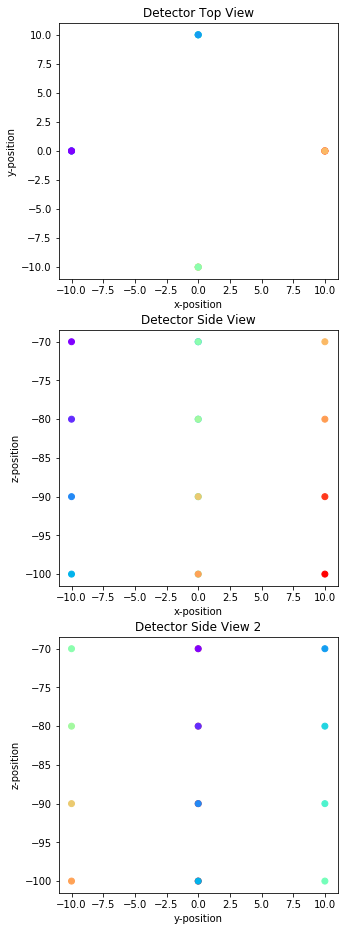

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(5, 16))
ax[0].scatter([ant.position[0] for ant in det],
              [ant.position[1] for ant in det],
              c=trig_times, cmap='rainbow_r')
ax[0].set_title("Detector Top View")
ax[0].set_xlabel("x-position")
ax[0].set_ylabel("y-position")
ax[1].scatter([ant.position[0] for ant in det],
              [ant.position[2] for ant in det],
              c=trig_times, cmap='rainbow_r')
ax[1].set_title("Detector Side View")
ax[1].set_xlabel("x-position")
ax[1].set_ylabel("z-position")
ax[2].scatter([ant.position[1] for ant in det],
              [ant.position[2] for ant in det],
              c=trig_times, cmap='rainbow_r')
ax[2].set_title("Detector Side View 2")
ax[2].set_xlabel("y-position")
ax[2].set_ylabel("z-position")
plt.show()